In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse
import nltk

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [4]:
from pymystem3 import Mystem
mystem = Mystem()

In [5]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.metrics  import classification_report

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wizard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:40, 4990.48it/s]


Рассмотрим пример отзыва:



In [8]:
responses[99]


{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [9]:
df = pd.DataFrame(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


## Часть 1. Анализ текстов


Посчитайте количество отзывов в разных городах и на разные банки



In [11]:
df.groupby(df.city)['title'].count()


city
г.  (Красногорск)                           1
г.  (Москва)                                2
г.  (Россия)                                1
г.  (Ханты-Мансийский автономный округ)     1
г. -                                        1
                                           ..
г. ялуторовск                               1
г. янаул                                    2
г. ярославль                               12
г. ярцево                                   2
г. … или другой населенный пункт            1
Name: title, Length: 5823, dtype: int64

In [12]:
df.groupby(df.bank_name)['title'].count()


bank_name
2Т Банк          655
АБ Финанс         23
АББ                2
АМБ Банк           1
АМТ Банк         142
                ... 
Юнистрим          81
ЯР-Банк           12
Яндекс.Деньги    226
Ярославич          5
Ярсоцбанк          7
Name: title, Length: 670, dtype: int64

Постройте гистограмы длин текстов в символах и в словах



In [13]:
from sklearn.feature_extraction.text import CountVectorizer


In [14]:
vec_words = CountVectorizer(ngram_range=(1, 1), stop_words=stopwords.words('russian'))
bow_words = vec_words.fit_transform(df.text)
vec_symbol = CountVectorizer(analyzer='char')
bow_symbol = vec_symbol.fit_transform(df.text)

In [15]:
ln_words = []
ln_symbol = []
for i in range(1000):
    ln_words.append(np.sum(bow_words[i].todense()))
    ln_symbol.append(np.sum(bow_symbol[i].todense()))

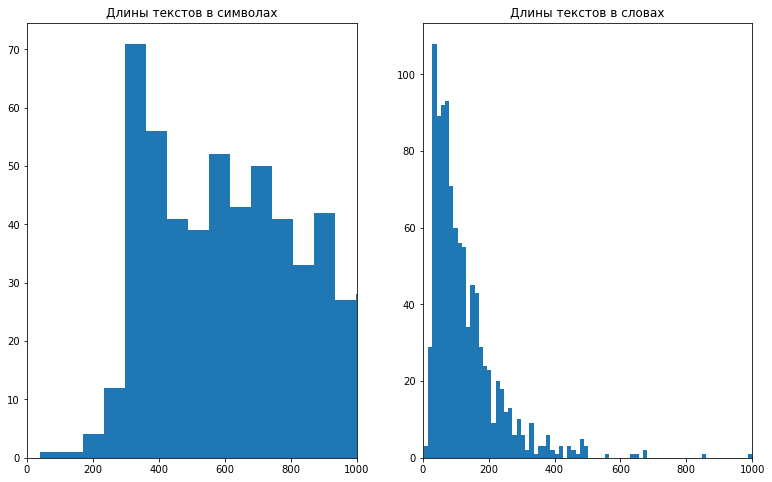

In [16]:
fig, axes = plt.subplots(1, 2,figsize=(13,8))

axes[0].hist(ln_symbol, bins = 200)
axes[0].set_xlim(0, 1000)
axes[1].hist(ln_words, bins = 100)
axes[1].set_xlim(0, 1000)
axes[0].set_title(u"Длины текстов в символах")
axes[1].set_title(u"Длины текстов в словах")
fig.show()

Найдите 10 самых частых:
 * слов
 * слов без стоп-слов
 * лемм
 * существительных

In [17]:
# слов
sorted(list(zip(vec_words.vocabulary_.keys(), bow_words.sum(0).getA1())), key = lambda i: i[1], reverse =True)[:10]


[('спрашивающего', 275765),
 ('погуглила', 215209),
 ('пащинская', 183365),
 ('нескончаемыми', 131197),
 ('1067184', 105824),
 ('гренбери', 101814),
 ('староневский', 81116),
 ('32541', 76546),
 ('буфеты', 72085),
 ('радикальных', 70422)]

In [18]:
# слов без стоп-слов
vec = CountVectorizer(ngram_range=(1, 1), stop_words=None)
bow = vec.fit_transform(df.text)
sorted(list(zip(vec.vocabulary_.keys(), bow.sum(0).getA1())), key = lambda i: i[1], reverse =True)[:10]

[('отвечавшая', 852416),
 ('табак', 707784),
 ('выдворят', 640053),
 ('вызови', 372738),
 ('отличавшееся', 320956),
 ('вежливами', 275765),
 ('радыгин', 215209),
 ('устраивался', 205679),
 ('352501001', 200416),
 ('walk', 192847)]

In [19]:
df = df.dropna()


In [20]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 74710 entries, 14 to 138946
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                74710 non-null  object 
 1   rating_not_checked  74710 non-null  bool   
 2   title               74710 non-null  object 
 3   num_comments        74710 non-null  int64  
 4   bank_license        74710 non-null  object 
 5   author              74710 non-null  object 
 6   bank_name           74710 non-null  object 
 7   datetime            74710 non-null  object 
 8   text                74710 non-null  object 
 9   rating_grade        74710 non-null  float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 5.8+ MB


In [21]:
Y = df.rating_grade


In [22]:
X = df.drop('rating_grade', axis=1)


In [23]:
# С целью уменьшения нагрузки на процессор сделаем выборку из датасета
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.1, random_state=42, stratify = Y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7471, 9), (67239, 9), (7471,), (67239,))

In [24]:
X = X_train
Y = y_train

In [25]:
# лемм
lemmas1 = [morph.parse(word)[0].normal_form for word in X.text.to_string().lower().split()]
vec_lemm = CountVectorizer(ngram_range=(1, 1), stop_words=stopwords.words('russian'))
bow_lemm = vec_lemm.fit_transform(lemmas1)
sorted(list(zip(vec_lemm.vocabulary_.keys(), bow_lemm.sum(0).getA1())), key = lambda i: i[1], reverse =True)[:10]

[('онлай', 1390),
 ('111454', 866),
 ('92749', 784),
 ('6362', 718),
 ('праздника', 553),
 ('процен', 542),
 ('117824', 484),
 ('42762', 428),
 ('61592', 385),
 ('неск', 367)]

In [26]:
# существительных
 
noun = [word for word in lemmas1 if morph.parse(word)[0].tag.POS=='NOUN' ]
noun
vec_noun = CountVectorizer(ngram_range=(1, 1))
bow_noun = vec_noun.fit_transform(noun)
sorted(list(zip(vec_noun.vocabulary_.keys(), bow_noun.sum(0).getA1())), key = lambda i: i[1], reverse =True)[:10]

[('расторжение', 1223),
 ('кэш', 685),
 ('дезинформация', 539),
 ('оценка', 471),
 ('елизар', 301),
 ('номос', 294),
 ('адаптация', 274),
 ('красноярск', 182),
 ('кононов', 180),
 ('проспект', 176)]

## Постройте кривые Ципфа и Хипса


In [27]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [28]:
from collections import Counter
corpus = [token for tweet in X.text for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

2050615


['В',
 'Раменском',
 'ДО',
 'банка',
 'ВТБ',
 '24',
 'полтора',
 'месяца',
 'назад',
 'заказал']

In [29]:
freq_dict = Counter(corpus)

# freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
freq_dict.most_common(10)

[('в', 66171),
 ('и', 55441),
 ('не', 45396),
 ('на', 35308),
 ('что', 34807),
 ('я', 24682),
 ('с', 23614),
 ('по', 18655),
 ('мне', 16733),
 ('банка', 13104)]

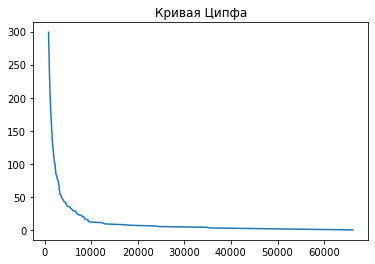

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
ax.set_title(u'Кривая Ципфа', fontsize=12)
plt.show()

In [31]:
cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(X.iterrows(), total = len(X)):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))

100%|██████████████████████████████████████| 7471/7471 [00:45<00:00, 165.87it/s]


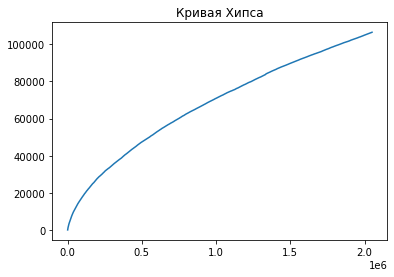

In [32]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
ax.set_title(u'Кривая Хипса', fontsize=12)
plt.show()

Ответьте на следующие вопросы:

Какое слово встречается чаще, "сотрудник" или "клиент"?

Сколько раз встречается слова "мошенничество" и "доверие"?

In [33]:
for  i in ["сотрудник", "клиент", "мошенничество", "доверие"]:
    print(i, freq_dict.get(i))

сотрудник 1586
клиент 839
мошенничество 44
доверие 45


In [34]:
positive = df.loc[df.rating_grade==5]
negative = df.loc[df.rating_grade==1]

In [35]:
vec = TfidfVectorizer(ngram_range=(1, 1), stop_words=stopwords.words('russian'))
bow = vec.fit(df.title)

In [36]:
print('Ключевые слова для положительных отзывов')
bow_pls = bow.transform(positive.title)
sorted(list(zip(vec.vocabulary_.keys(), bow_pls.sum(0).getA1())), key = lambda i: i[1], reverse =True)[:10]

Ключевые слова для положительных отзывов


[('проблемами', 395.40761430558575),
 ('теряет', 368.233497444977),
 ('59р', 321.3188033696577),
 ('вынуждающее', 251.51163214893674),
 ('вину', 184.50265894687792),
 ('рассрочкой', 130.49433088983287),
 ('горькое', 105.3107339908883),
 ('строить', 104.89816666316145),
 ('начхать', 102.70455261485913),
 ('принесет', 99.939706225379)]

In [37]:
print('Ключевые слова для отрицательных отзывов')
bow_neg = bow.transform(negative.title)
sorted(list(zip(vec.vocabulary_.keys(), bow_neg.sum(0).getA1())), key = lambda i: i[1], reverse =True)[:10]

Ключевые слова для отрицательных отзывов


[('недобросовестный', 959.9768563602177),
 ('проблемами', 852.6879745027343),
 ('рассрочкой', 708.3132166096443),
 ('великолепно', 523.7249093600086),
 ('вынуждающее', 498.2691170039271),
 ('людям', 480.92799949253595),
 ('человеком', 402.80934368368474),
 ('пределе', 375.33057133743904),
 ('среднем', 369.4893102100691),
 ('побывать', 357.67534090534133)]

In [38]:
vec = TfidfVectorizer(ngram_range=(2, 2), stop_words=stopwords.words('russian'))
bow = vec.fit(df.title)

In [39]:
print('Биграммы для положительных отзывов')
bow_pls = bow.transform(positive.title)
sorted(list(zip(vec.vocabulary_.keys(), bow_pls.sum(0).getA1())), key = lambda i: i[1], reverse =True)[:10]

Биграммы для положительных отзывов


[('сюрприз хоума', 145.05761154080105),
 ('деньги те', 84.66114249317523),
 ('ижевске понравилось', 72.64409162293431),
 ('зависло зависло', 62.243840246095445),
 ('сотрудники дилетанты', 51.27494515467641),
 ('руб акции', 46.208923944103425),
 ('списанные средства', 43.00136248829607),
 ('добиться регулярного', 42.199609721699694),
 ('могу добиться', 36.86302736821293),
 ('банке закрытии', 35.291973612743945)]

In [41]:
print('Биграммы для отрицательных отзывов')
bow_neg = bow.transform(negative.title)
sorted(list(zip(vec.vocabulary_.keys(), bow_neg.sum(0).getA1())), key = lambda i: i[1], reverse =True)[:10]


Биграммы для отрицательных отзывов


[('банка рс', 178.33602333094484),
 ('полезности бесцельных', 175.6623771811733),
 ('банк выполнять', 160.2605832228851),
 ('перевод ленинском', 142.83035875679047),
 ('выдали денежные', 132.6915789856816),
 ('телефон бесконечные', 125.08112310306095),
 ('заботится сохранении', 120.90813498566939),
 ('воза упало', 116.6920572966939),
 ('сергея николаевича', 112.69620579659352),
 ('услуга процентов', 109.23015667744804)]

## Часть 2. Тематическое моделирование

Постройте несколько тематических моделей коллекции документов с разным числом тем.

Приведите примеры понятных (интерпретируемых) тем.
Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк).
Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.

In [42]:
pip install --upgrade gensim


     |████████████████████████████████| 24.0 MB 1.6 MB/s eta 0:00:01     |███████████████▉                | 11.8 MB 3.0 MB/s eta 0:00:04
  Attempting uninstall: gensim
    Found existing installation: gensim 4.1.2
    Uninstalling gensim-4.1.2:
      Successfully uninstalled gensim-4.1.2
Note: you may need to restart the kernel to use updated packages.


In [43]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [44]:
mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой'
]
ru_words = re.compile("[А-Яа-я]+")


def words_only(text):
    return " ".join(ru_words.findall(text))


def lemmat(text):   
    try:
        return " ".join([morph.parse(word)[0].normal_form for word in text.split()]).strip()
    except:
        return ""

def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
def preprocess(text):
    return remove_stopwords(lemmat(words_only(text.lower())))


In [45]:
text = X.text.apply(preprocess)
text


30773     раменское банк втб полтора месяц назад заказат...
60894     петербург иметь верный пока ещё иметь вклад да...
77365     прекрасный день август зайти телебанк день ста...
53610     обратиться банк оформление ипотека программа и...
71768     очень просить разобраться ваш сотрудник работа...
                                ...                        
24423     брать кредит год ставка первый год далее моспр...
122241    здравствуйте наверное пока отзыв корректный не...
51540     приветствовать весь клиент мособобанк сотрудни...
58679     сегодня утро прочитать сайт банк акция бесплат...
55431     февраль снимать зара плата терминал сбербанк к...
Name: text, Length: 7471, dtype: object

In [47]:
texts = [text1.split() for text1 in text]


In [48]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [49]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]


In [50]:
corpus_tfidf


In [51]:
# %%time
index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

In [52]:
len(corpus)


7471

In [53]:
sims[0]


array([1.0000001 , 0.00881498, 0.01472582, ..., 0.00883962, 0.0078349 ,
       0.00754035], dtype=float32)

In [54]:
sims.shape


(7471, 7471)

In [55]:
from gensim.models import lsimodel


In [56]:
# 5 тем
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)


In [57]:
lsi.show_topics(5)


[(0,
  '0.194*"карта" + 0.135*"кредит" + 0.116*"вклад" + 0.115*"заявление" + 0.112*"банкомат" + 0.111*"деньга" + 0.106*"счёт" + 0.099*"отделение" + 0.098*"сбербанк" + 0.093*"сумма"'),
 (1,
  '0.616*"вклад" + -0.190*"кредит" + 0.154*"очередь" + -0.138*"заявление" + -0.136*"платёж" + 0.135*"открыть" + -0.115*"задолженность" + -0.112*"погашение" + 0.099*"касса" + 0.091*"офис"'),
 (2,
  '0.424*"банкомат" + -0.375*"кредит" + -0.216*"страховка" + 0.211*"карта" + -0.171*"договор" + 0.158*"сбербанк" + 0.153*"деньга" + -0.136*"страхование" + 0.127*"операция" + -0.124*"погашение"'),
 (3,
  '0.312*"банкомат" + -0.309*"карта" + 0.306*"вклад" + -0.200*"заявка" + 0.176*"сумма" + 0.154*"деньга" + 0.132*"погашение" + 0.126*"кредит" + 0.124*"руб" + 0.121*"платёж"'),
 (4,
  '-0.407*"банкомат" + 0.270*"вклад" + 0.262*"карта" + -0.165*"кредит" + -0.163*"заявка" + 0.138*"счёт" + -0.129*"очередь" + -0.129*"купюра" + 0.128*"задолженность" + 0.112*"комиссия"')]

In [58]:
# 30 тем
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

In [59]:
lsi.show_topics(5)


[(0,
  '0.194*"карта" + 0.135*"кредит" + 0.116*"вклад" + 0.115*"заявление" + 0.112*"банкомат" + 0.111*"деньга" + 0.106*"счёт" + 0.099*"отделение" + 0.098*"сбербанк" + 0.093*"сумма"'),
 (1,
  '-0.616*"вклад" + 0.190*"кредит" + -0.155*"очередь" + 0.137*"заявление" + 0.136*"платёж" + -0.135*"открыть" + 0.116*"задолженность" + 0.112*"погашение" + -0.099*"касса" + -0.090*"офис"'),
 (2,
  '-0.424*"банкомат" + 0.375*"кредит" + 0.216*"страховка" + -0.210*"карта" + 0.170*"договор" + -0.159*"сбербанк" + -0.153*"деньга" + 0.136*"страхование" + -0.128*"операция" + 0.124*"погашение"'),
 (3,
  '-0.314*"банкомат" + -0.307*"вклад" + 0.307*"карта" + 0.201*"заявка" + -0.176*"сумма" + -0.152*"деньга" + -0.134*"погашение" + -0.126*"руб" + -0.126*"кредит" + -0.122*"платёж"'),
 (4,
  '0.406*"банкомат" + -0.271*"вклад" + -0.264*"карта" + 0.166*"кредит" + 0.161*"заявка" + -0.141*"счёт" + 0.130*"очередь" + 0.130*"купюра" + -0.126*"задолженность" + -0.111*"комиссия"')]

### Понятные темы: карта, кредит, вклад, банкомат


In [60]:
for i in range(30):    
    for j in lsi.show_topic(topicno=i, topn=10):
        if j[0] in ['сбербанк', 'альфа', 'втб']:
            print('topic =', i, j)

topic = 0 ('сбербанк', 0.0980943581036627)
topic = 2 ('сбербанк', -0.15873563921587056)
topic = 5 ('сбербанк', -0.11576847908090707)
topic = 6 ('сбербанк', 0.25909345568352454)
topic = 7 ('сбербанк', 0.31932599017159163)
topic = 8 ('сбербанк', -0.2726380884852816)
topic = 10 ('сбербанк', -0.23481101802920562)
topic = 10 ('альфа', 0.12575189063278855)
topic = 11 ('сбербанк', -0.3858023095820332)
topic = 12 ('сбербанк', -0.2349135468044132)
topic = 13 ('сбербанк', -0.1503482740750993)
topic = 14 ('сбербанк', -0.1543471437556309)
topic = 14 ('альфа', -0.1452162720928645)
topic = 16 ('альфа', -0.1548873989862213)
topic = 17 ('альфа', 0.1508717974026932)
topic = 20 ('альфа', 0.31469082550579436)
topic = 21 ('альфа', 0.20463189478481683)
topic = 22 ('альфа', -0.4315983861659176)
topic = 23 ('втб', -0.203680565035125)
topic = 24 ('альфа', 0.19490888558847116)
topic = 26 ('альфа', -0.1496127909416281)
topic = 29 ('альфа', -0.1562989986461048)


## Часть 3. Классификация текстов


Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).
Составьте обучающее и тестовое множество: **выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение).

In [61]:
data = pd.concat([positive.iloc[:3000], negative.iloc[:3000]])


Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

In [62]:
X_train, X_test, y_train, y_test = train_test_split(data.text, data.rating_grade, train_size=0.7, random_state=42, stratify = data.rating_grade)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4200,), (1800,), (4200,), (1800,))

In [63]:
X_train = X_train.apply(preprocess)
X_train

26854    покупка машина потребоваться доплата принцип н...
3318     декабрь заблокировать карта написать заявление...
585      здравствуйте сразу написать являться клиент ба...
10647    обслуживание сбербанк бум переров корпус рядом...
10814    здравствуйте способ вывод карта информация пла...
                               ...                        
33222    узнать банк случайно поездка прага решить запа...
6616     являться клиент банк год никакой проблема всё ...
3299     март месяц день получить зарплатный карточка с...
7463     добрый день лебедев владимир являться х год за...
5602     добрый день декабрь год оформить ипотечный кре...
Name: text, Length: 4200, dtype: object

In [64]:
X_test = X_test.apply(preprocess)
X_test

8619     хотеть поблагодарить сотрудник отдел претензио...
4672     очень сильно мешать жить постоянный звонок соо...
2144     год назад жена сделать вклад ваш банк примерно...
5546     снимать деньга банкомат банкомат списать деньг...
9623     март г организация подать исполнительный лист ...
                               ...                        
31492    добрый день обычно отзыв читать решить написат...
45281    вообще ткс банк виртуальный поддержка должный ...
4810     добрый день март год адрес путём почтовый отпр...
43653    перевести телефон рубль пользоваться очень нес...
9997     добрый день май оформить кредит телефон связны...
Name: text, Length: 1800, dtype: object

Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline.
Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных -грам.
Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
1-ый вариант: преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации. 

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [66]:
# 1-вариант: 𝑡𝑓−𝑖𝑑𝑓  преобразование  и сингулярное разложение
dic = [((1, 1)), ((2, 2)), ((3, 3))]
for i in dic:
    clf = Pipeline([ 
        ('vect', CountVectorizer(ngram_range=i)), 
        ('tfidf', TfidfTransformer()), 
        ('tm', TruncatedSVD()), 
        ('clf', RandomForestClassifier(criterion='entropy', n_estimators=10, max_depth=2, random_state=0))
    ])
    clf.fit(X_train, y_train)  
    pred = clf.predict(X_test)
    print(classification_report(pred, y_test))
    print('____________________________________')
clf = Pipeline([ 
        ('vect', CountVectorizer(analyzer='char')), 
        ('tfidf', TfidfTransformer()), 
        ('tm', TruncatedSVD()), 
        ('clf', RandomForestClassifier(criterion='entropy', n_estimators=10, max_depth=3, random_state=0))
    ])
clf.fit(X_train, y_train)  
pred = clf.predict(X_test)
print(classification_report(pred, y_test))    

              precision    recall  f1-score   support

         1.0       0.82      0.76      0.79       971
         5.0       0.74      0.80      0.77       829

    accuracy                           0.78      1800
   macro avg       0.78      0.78      0.78      1800
weighted avg       0.78      0.78      0.78      1800

____________________________________
              precision    recall  f1-score   support

         1.0       0.83      0.81      0.82       925
         5.0       0.81      0.83      0.82       875

    accuracy                           0.82      1800
   macro avg       0.82      0.82      0.82      1800
weighted avg       0.82      0.82      0.82      1800

____________________________________
              precision    recall  f1-score   support

         1.0       0.94      0.54      0.69      1574
         5.0       0.19      0.77      0.31       226

    accuracy                           0.57      1800
   macro avg       0.57      0.66      0.50      1800


In [67]:
# 2-й вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation)
dic = [((1, 1)), ((2, 2)), ((3, 3))]
for i in dic:
    clf = Pipeline([ 
        ('vect', CountVectorizer(ngram_range=i)), 
        ('tfidf', TfidfTransformer()), 
        ('lda', LatentDirichletAllocation()), 
        ('clf', RandomForestClassifier(criterion='entropy', n_estimators=10, max_depth=2, random_state=0))
    ])
    clf.fit(X_train, y_train)  
    pred = clf.predict(X_test)
    print(classification_report(pred, y_test))
    print('____________________________________')
clf = Pipeline([ 
        ('vect', CountVectorizer(analyzer='char')), 
        ('tfidf', TfidfTransformer()), 
        ('lda', LatentDirichletAllocation()), 
        ('clf', RandomForestClassifier(criterion='entropy', n_estimators=10, max_depth=3, random_state=0))
    ])
clf.fit(X_train, y_train)  
pred = clf.predict(X_test)
print(classification_report(pred, y_test))    

              precision    recall  f1-score   support

         1.0       0.84      0.53      0.65      1410
         5.0       0.27      0.63      0.38       390

    accuracy                           0.55      1800
   macro avg       0.55      0.58      0.52      1800
weighted avg       0.71      0.55      0.59      1800

____________________________________
              precision    recall  f1-score   support

         1.0       0.89      0.52      0.66      1538
         5.0       0.18      0.62      0.28       262

    accuracy                           0.54      1800
   macro avg       0.54      0.57      0.47      1800
weighted avg       0.79      0.54      0.60      1800

____________________________________
              precision    recall  f1-score   support

         1.0       0.96      0.50      0.65      1739
         5.0       0.02      0.36      0.05        61

    accuracy                           0.49      1800
   macro avg       0.49      0.43      0.35      1800


1-й вариант отработал быстрее и лучше на словах, и сравнимо со 2-м вариантом на символьных n-граммах